In [ ]:
!pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from deepxde.backend import tf
from mpl_toolkits.axes_grid1 import make_axes_locatable

Using backend: tensorflow.compat.v1

Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



Heat equation with Neumann boundary conditions:

$u_t + D u_{xx} = 0, \ x \in [0,1], \ t \in [0,1]$ \\
$u_x(0,t) = u_x(0, t) = 0, \ t \in [0,1]$ \\
$u(x, 0) = \sin^4(\pi x), \ x \in [0,1]$

In [ ]:
D = 0.03

def pde(x, u):
  du_t = dde.gradients.jacobian(u, x, i=0, j=1)
  du_xx = dde.gradients.hessian(u, x, i=0, j=0)
  return du_t - D * du_xx

def boundary_bc(x, on_boundary):
  return on_boundary and (np.isclose(x[0], 0) or np.isclose(x[0], 1))

def boundary_ic(x, on_initial):
  return on_initial and np.isclose(x[1], 0)

def boundary_conditon(x):
  return np.zeros((x.shape[0], 1))

def initial_condition(x):
  return np.sin(np.pi * x[:, 0:1])**4

Analytical solution: $u(x, t) = \frac{3}{8} - \frac{1}{2} e^{-4 \pi^2 D t} \cos(2 \pi x) + \frac{1}{8} e^{-16 \pi^2 D t} \cos(4 \pi x)$

In [ ]:
def solution(X):
  x, t = X[:, 0:1], X[:, 1:2]
  return 0.375 - 0.5 * np.exp(-4 * t * D * np.pi**2) * np.cos(2 * np.pi * x) + \
    0.125 * np.exp(-16 * t * D * np.pi**2) * np.cos(4 * np.pi * x)

Plotting the analytical solution

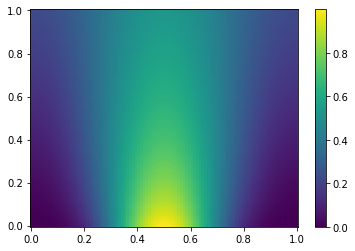

In [ ]:
x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
x, t = np.meshgrid(x, t)
X = np.column_stack((x.flatten(), t.flatten()))
u_true = solution(X)

c = plt.pcolormesh(X[:, 0].reshape(100, 100), X[:, 1].reshape(100, 100), u_true.reshape(100, 100), cmap='viridis')
plt.colorbar(c)
plt.show()

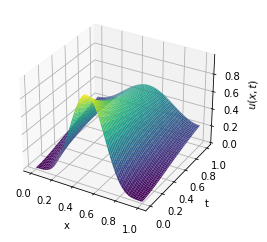

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$u(x,t)$')
ax.plot_surface(X[:, 0].reshape(100, 100), X[:, 1].reshape(100, 100), u_true.reshape(100, 100), cmap='viridis', edgecolor='none')

# PINN

PINN with a FNN having 3 hidden layers with 32 neurons each and $tanh$ activation function. The model is trained for 30000 iterations of the Adam optimizer and some iterations of L-BFGS. The number of points for the training process and the weights for the boundary constraints are parametric. In the first example, the weights are all 1 and the following points were selected: 200 points inside the domain, 20 in the boundary of x and 20 for the initial condition.

Compiling model...
Building feed-forward neural network...
'build' took 0.080321 s

'compile' took 0.789381 s

Initializing variables...
Training model...

0         [5.67e-02, 4.28e-03, 3.12e-01]    [5.67e-02, 4.28e-03, 3.12e-01]    []  
1000      [5.79e-04, 6.83e-05, 4.13e-04]    [5.79e-04, 6.83e-05, 4.13e-04]    []  
2000      [1.83e-04, 1.68e-05, 1.27e-04]    [1.83e-04, 1.68e-05, 1.27e-04]    []  
3000      [1.18e-04, 6.98e-06, 8.60e-05]    [1.18e-04, 6.98e-06, 8.60e-05]    []  
4000      [8.44e-05, 5.79e-06, 7.13e-05]    [8.44e-05, 5.79e-06, 7.13e-05]    []  
5000      [6.38e-05, 5.10e-06, 6.12e-05]    [6.38e-05, 5.10e-06, 6.12e-05]    []  
6000      [5.16e-05, 3.70e-06, 5.16e-05]    [5.16e-05, 3.70e-06, 5.16e-05]    []  
7000      [4.41e-05, 2.58e-06, 4.24e-05]    [4.41e-05, 2.58e-06, 4.24e-05]    []  
8000      [3.92e-05, 2.44e-06, 3.40e-05]    [3.92e-05, 2.44e-06, 3.40e-05]    []  
9000      [3.66e-05, 2.33e-05, 3.28e-05]    [3.66e-05, 2.33e-05, 3.28e-05]    []  
10000     [3.2

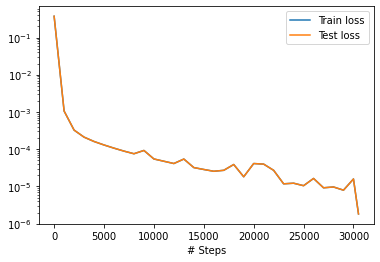

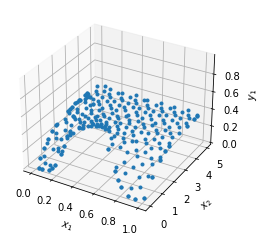

In [ ]:
def train(weights, num_domain, num_boundary, num_initial):
  geo_domain = dde.geometry.geometry_1d.Interval(0, 1)
  time_domain = dde.geometry.timedomain.TimeDomain(0, 5)
  geomtime = dde.geometry.GeometryXTime(geo_domain, time_domain)

  ic = dde.icbc.initial_conditions.IC(geomtime, initial_condition, boundary_ic)
  bc = dde.icbc.boundary_conditions.NeumannBC(geomtime, boundary_conditon, boundary_bc)
  data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=num_domain, num_boundary=num_boundary, num_initial=num_initial)

  layer_size = [2] + [32] * 3 + [1]
  activation = "tanh"
  initializer = "Glorot uniform"
  net = dde.nn.FNN(layer_size, activation, initializer)

  model = dde.Model(data, net)
  model.compile("adam", lr=1e-3, loss_weights=weights)
  losshistory, train_state = model.train(iterations=30000)
  model.compile("L-BFGS", loss_weights=weights)
  losshistory, train_state = model.train()
  return losshistory, train_state, model

losshistory, train_state, model = train([1, 1, 1], 200, 20, 20)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Calculating the mean PDE residual and the l2 relative error of the model.

In [ ]:
u_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(u_true, u_pred))

Mean residual: 0.009851119
L2 relative error: 0.005798311309355999


Plotting the prediction, the absolute value of the error in the prediction and the PDE residual in each area.

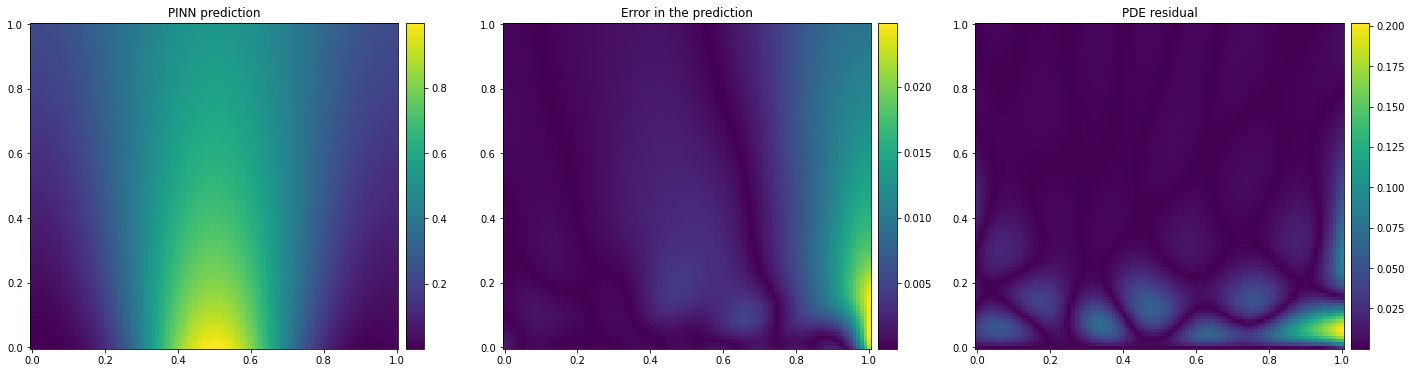

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

plot0 = axs[0].pcolormesh(X[:, 0].reshape(100, 100), X[:, 1].reshape(100, 100), u_pred.reshape(100, 100), cmap='viridis')
axs[0].set_title('PINN prediction')
divider0 = make_axes_locatable(axs[0])
cax0 = divider0.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot0, cax=cax0, orientation='vertical')

error = np.absolute(u_true - u_pred)
plot1 = axs[1].pcolormesh(X[:, 0].reshape(100, 100), X[:, 1].reshape(100, 100), error.reshape(100, 100), cmap='viridis')
axs[1].set_title('Error in the prediction')
divider1 = make_axes_locatable(axs[1])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot1, cax=cax1, orientation='vertical')

residual = np.absolute(model.predict(X, operator=pde))
plot2 = axs[2].pcolormesh(X[:, 0].reshape(100, 100), X[:, 1].reshape(100, 100), residual.reshape(100, 100), cmap='viridis')
axs[2].set_title('PDE residual')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot2, cax=cax2, orientation='vertical')
plt.show()

# Points resampling

Here the PINN is trained using the PDE points resampling callback, that resample the training points in the domain every $k$ epochs (called period of the resampler)

`pde_resampler = dde.callbacks.PDEPointResampler(period=10)`

In this case, a period of 10 have been used. The first example contains the same parameters of the previous example without points resampling.

Compiling model...
Building feed-forward neural network...
'build' took 0.085250 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 4.134031 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.80e-02, 5.17e-02, 1.83e-01]    [2.80e-02, 5.17e-02, 1.83e-01]    []  
1000      [8.24e-04, 1.28e-04, 2.60e-04]    [9.02e-04, 1.28e-04, 2.60e-04]    []  
2000      [1.00e-04, 4.27e-06, 2.89e-05]    [1.33e-04, 4.27e-06, 2.89e-05]    []  
3000      [3.90e-05, 2.11e-04, 6.57e-05]    [1.07e-04, 2.11e-04, 6.57e-05]    []  
4000      [6.74e-05, 1.21e-05, 2.01e-05]    [7.14e-05, 1.21e-05, 2.01e-05]    []  
5000      [5.84e-05, 6.51e-06, 1.47e-05]    [6.01e-05, 6.51e-06, 1.47e-05]    []  
6000      [1.52e-05, 4.71e-07, 1.23e-05]    [6.76e-05, 4.71e-07, 1.23e-05]    []  
7000      [4.31e-05, 2.61e-06, 1.16e-05]    [4.63e-05, 2.61e-06, 1.16e-05]    []  
8000      [2.76e-05, 2.35e-05, 1.37e-05]    [4.52e-05, 2.35e-05, 1.37e-05]    []  
9000      [1.15e-05, 4.08e-07, 9.01e-06]    [4.90e-05, 4.08e-07, 9.01e-06]    []  
10000   

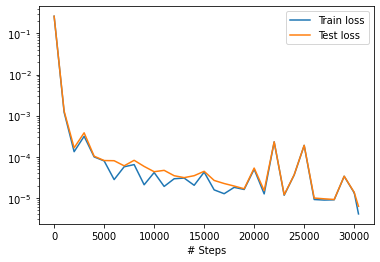

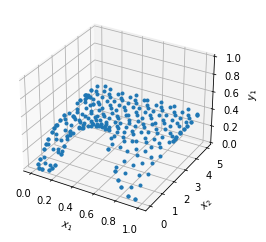

In [ ]:
def train_resampler(weights, num_domain, num_boundary, num_initial):
  geo_domain = dde.geometry.geometry_1d.Interval(0, 1)
  time_domain = dde.geometry.timedomain.TimeDomain(0, 5)
  geomtime = dde.geometry.GeometryXTime(geo_domain, time_domain)

  ic = dde.icbc.initial_conditions.IC(geomtime, initial_condition, boundary_ic)
  bc = dde.icbc.boundary_conditions.NeumannBC(geomtime, boundary_conditon, boundary_bc)
  data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=num_domain, num_boundary=num_boundary, num_initial=num_initial)

  layer_size = [2] + [32] * 3 + [1]
  activation = "tanh"
  initializer = "Glorot uniform"
  net = dde.nn.FNN(layer_size, activation, initializer)

  model = dde.Model(data, net)

  pde_resampler = dde.callbacks.PDEPointResampler(period=10)

  model.compile("adam", lr=1e-3, loss_weights=weights)
  losshistory, train_state = model.train(iterations=30000, callbacks=[pde_resampler])
  model.compile("L-BFGS", loss_weights=weights)
  losshistory, train_state = model.train(callbacks=[pde_resampler])
  return losshistory, train_state, model

losshistory, train_state, model_resampler = train_resampler([1, 1, 1], 200, 20, 20)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Calculating the mean PDE residual and the l2 relative error of the model.

In [ ]:
u_pred = model_resampler.predict(X)
f = model_resampler.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(u_true, u_pred))

Mean residual: 0.005801373
L2 relative error: 0.019461665038913174


Plotting the prediction, the absolute value of the error in the prediction and the PDE residual in each area.

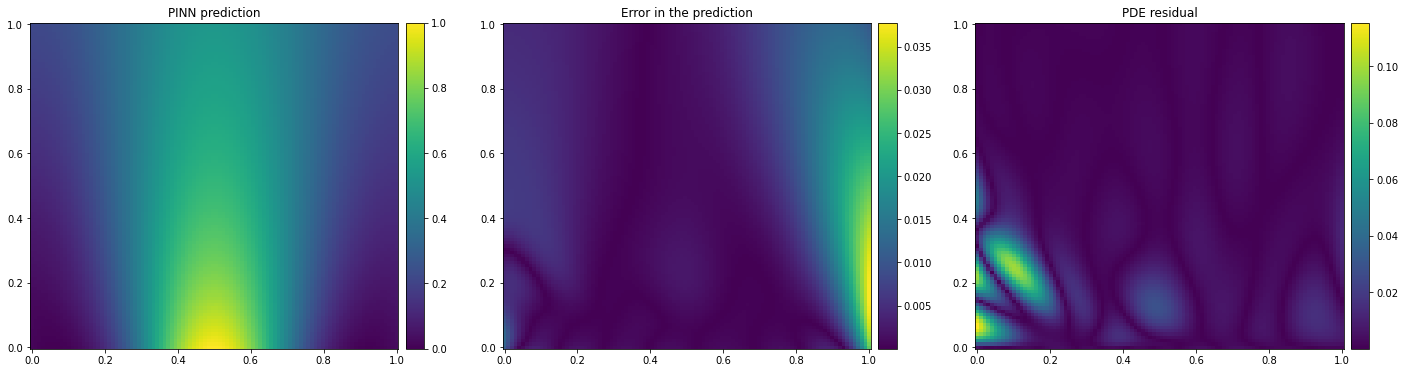

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

plot0 = axs[0].pcolormesh(X[:, 0].reshape(100, 100), X[:, 1].reshape(100, 100), u_pred.reshape(100, 100), cmap='viridis')
axs[0].set_title('PINN with PDE resampling prediction')
divider0 = make_axes_locatable(axs[0])
cax0 = divider0.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot0, cax=cax0, orientation='vertical')

error = np.absolute(u_true - u_pred)
plot1 = axs[1].pcolormesh(X[:, 0].reshape(100, 100), X[:, 1].reshape(100, 100), error.reshape(100, 100), cmap='viridis')
axs[1].set_title('Error in the prediction')
divider1 = make_axes_locatable(axs[1])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot1, cax=cax1, orientation='vertical')

residual = np.absolute(model_resampler.predict(X, operator=pde))
plot2 = axs[2].pcolormesh(X[:, 0].reshape(100, 100), X[:, 1].reshape(100, 100), residual.reshape(100, 100), cmap='viridis')
axs[2].set_title('PDE residual')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot2, cax=cax2, orientation='vertical')
plt.show()

# Comparison with different weights and domain points

Calculating the PDE mean residual and the l2 relative error for a PINN with and without points resampling, using a different number of training points inside the domain and different values for the weights for the boundary conditions.

In [ ]:
domain_points = np.array([100, 200, 300, 400, 500, 600, 700, 800])
weights_bc_ic = [1, 10, 0.1]
pinn = {1: {'r': list(), 'l2': list()}, 
        10: {'r': list(), 'l2': list()}, 
        0.1: {'r': list(), 'l2': list()}}
resampler = {1: {'r': list(), 'l2': list()}, 
             10: {'r': list(), 'l2': list()}, 
             0.1: {'r': list(), 'l2': list()}}

for w in weights_bc_ic:
  for num_domain in domain_points:
    _, _, model = train([1, w, w], num_domain, 30, 30)
    pinn[w]['r'].append(np.mean(np.absolute(model.predict(X, operator=pde))))
    pinn[w]['l2'].append(dde.metrics.l2_relative_error(u_true, model.predict(X)))

    _, _, model_resampler = train_resampler([1, w, w], num_domain, 30, 30)
    resampler[w]['r'].append(np.mean(np.absolute(model_resampler.predict(X, operator=pde))))
    resampler[w]['l2'].append(dde.metrics.l2_relative_error(u_true, model_resampler.predict(X)))

Compiling model...
Building feed-forward neural network...
'build' took 0.053249 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.904356 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.07e-02, 1.71e-02, 2.40e-01]    [4.07e-02, 1.71e-02, 2.40e-01]    []  
1000      [4.09e-04, 1.01e-04, 2.82e-04]    [4.09e-04, 1.01e-04, 2.82e-04]    []  
2000      [2.15e-04, 4.58e-05, 1.60e-04]    [2.15e-04, 4.58e-05, 1.60e-04]    []  
3000      [1.51e-04, 4.83e-05, 1.08e-04]    [1.51e-04, 4.83e-05, 1.08e-04]    []  
4000      [8.63e-05, 1.25e-05, 7.11e-05]    [8.63e-05, 1.25e-05, 7.11e-05]    []  
5000      [5.58e-05, 7.75e-06, 4.58e-05]    [5.58e-05, 7.75e-06, 4.58e-05]    []  
6000      [4.10e-05, 4.95e-06, 2.81e-05]    [4.10e-05, 4.95e-06, 2.81e-05]    []  
7000      [3.12e-05, 3.50e-06, 1.81e-05]    [3.12e-05, 3.50e-06, 1.81e-05]    []  
8000      [2.29e-05, 1.96e-06, 1.33e-05]    [2.29e-05, 1.96e-06, 1.33e-05]    []  
9000      [1.72e-05, 1.31e-06, 1.04e-05]    [1.72e-05, 1.31e-06, 1.04e-05]    []  
10000   

Plotting the results obtained for the mean PDE residual and for the l2 relative error

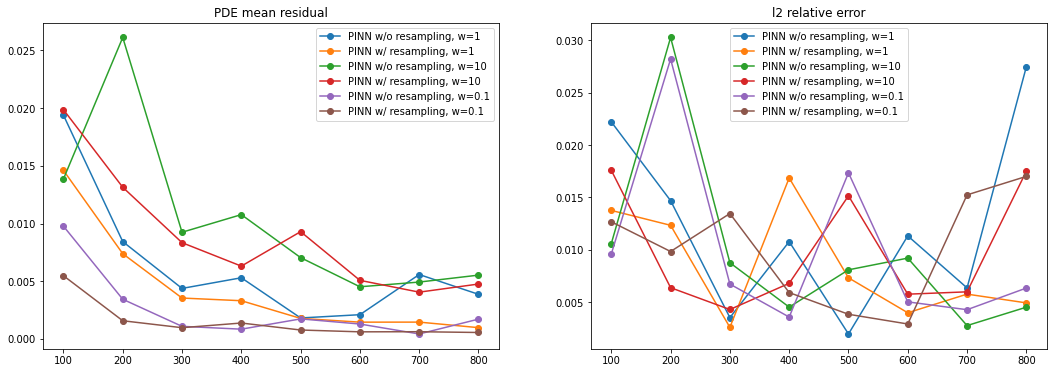

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

for w in weights_bc_ic:
  axs[0].plot(domain_points, np.array(pinn[w]['r']), 'o-', label=f'PINN w/o resampling, w={w}')
  axs[0].plot(domain_points, np.array(resampler[w]['r']), 'o-', label=f'PINN w/ resampling, w={w}')

  axs[1].plot(domain_points, np.array(pinn[w]['l2']), 'o-', label=f'PINN w/o resampling, w={w}')
  axs[1].plot(domain_points, np.array(resampler[w]['l2']), 'o-', label=f'PINN w/ resampling, w={w}')

axs[0].set_title('PDE mean residual')
axs[0].legend()
axs[1].set_title('l2 relative error')
axs[1].legend()

# RAR

Here the PINN is improved with RAR, using a maximum of 5 iterations and adding 10 points in each iteration. The parameters of the models are the same of the previous cases.

Compiling model...
Building feed-forward neural network...
'build' took 0.057307 s

'compile' took 0.507148 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.67e-02, 5.99e-02, 4.20e-01]    [2.67e-02, 5.99e-02, 4.20e-01]    []  
1000      [1.86e-03, 1.32e-04, 1.30e-03]    [1.86e-03, 1.32e-04, 1.30e-03]    []  
2000      [2.17e-04, 2.76e-05, 5.95e-05]    [2.17e-04, 2.76e-05, 5.95e-05]    []  
3000      [1.29e-04, 6.40e-05, 5.44e-05]    [1.29e-04, 6.40e-05, 5.44e-05]    []  
4000      [9.43e-05, 2.63e-04, 5.11e-05]    [9.43e-05, 2.63e-04, 5.11e-05]    []  
5000      [5.62e-05, 3.64e-05, 3.44e-05]    [5.62e-05, 3.64e-05, 3.44e-05]    []  
6000      [4.21e-05, 4.37e-05, 2.17e-05]    [4.21e-05, 4.37e-05, 2.17e-05]    []  
7000      [3.13e-05, 2.25e-06, 1.40e-05]    [3.13e-05, 2.25e-06, 1.40e-05]    []  
8000      [2.85e-05, 5.61e-06, 1.14e-05]    [2.85e-05, 5.61e-06, 1.14e-05]    []  
9000   

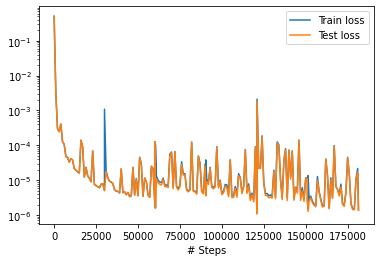

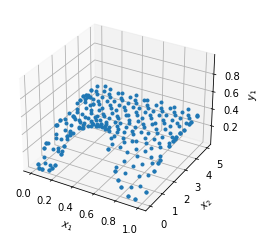

In [ ]:
geo_domain = dde.geometry.geometry_1d.Interval(0, 1)
time_domain = dde.geometry.timedomain.TimeDomain(0, 5)
geomtime = dde.geometry.GeometryXTime(geo_domain, time_domain)

ic = dde.icbc.initial_conditions.IC(geomtime, initial_condition, boundary_ic)
bc = dde.icbc.boundary_conditions.NeumannBC(geomtime, boundary_conditon, boundary_bc)
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=200, num_boundary=20, num_initial=20)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model_rar = dde.Model(data, net)
weights = [1, 1, 1]
model_rar.compile("adam", lr=1e-3, loss_weights=weights)
losshistory, train_state = model_rar.train(iterations=30000)
model_rar.compile("L-BFGS", loss_weights=weights)
losshistory, train_state = model_rar.train()

inputs = geomtime.random_points(10000)
error = 10
i = 0
m = 10
added_points = np.empty([0, 2])
while error > 0.0001 and i < 5:
  f_values = model_rar.predict(inputs, operator=pde)
  f_abs = np.absolute(f_values)
  error = np.mean(f_abs)
  print("mean error: ", error)

  top_m = np.argsort(f_abs.flatten())[::-1][:m]
  points_to_add = inputs[top_m]
  print("points added: ", points_to_add)
  data.add_anchors(points_to_add)
  added_points = np.vstack((added_points, points_to_add))

  model_rar.compile("adam", lr=1e-3, loss_weights=weights)
  losshistory, train_state = model_rar.train(iterations=30000, disregard_previous_best=True)
  model_rar.compile("L-BFGS", loss_weights=weights)
  losshistory, train_state = model_rar.train()
  i += 1

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Calculating the mean PDE residual and the l2 relative error of the model.

In [ ]:
u_pred = model_rar.predict(X)
f = model_rar.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(u_true, u_pred))

Mean residual: 0.0027931996
L2 relative error: 0.00899535492577513


Plotting the prediction, the absolute value of the error in the prediction and the PDE residual in each area. In additon, the points that were added during the process are shown in the first plot

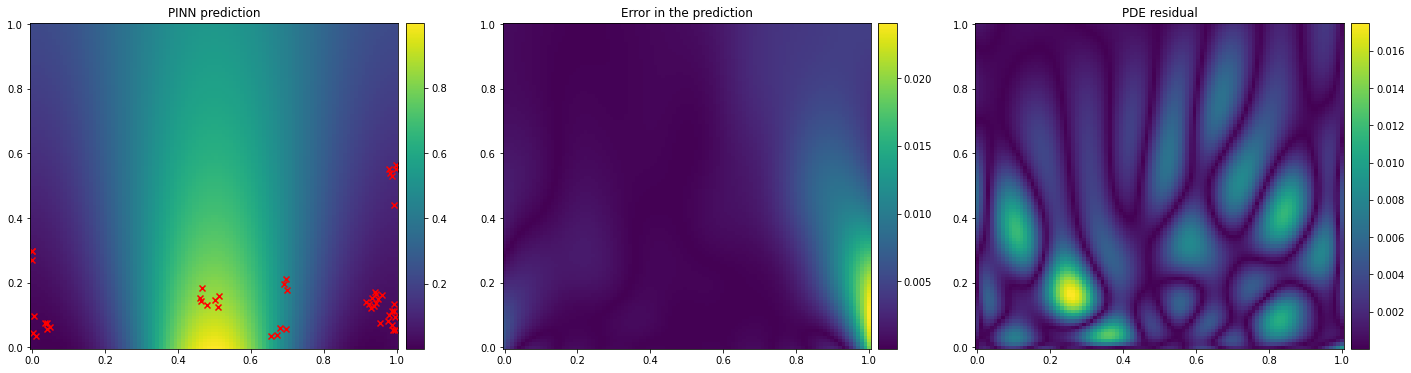

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

plot0 = axs[0].pcolormesh(X[:, 0].reshape(100, 100), X[:, 1].reshape(100, 100), u_pred.reshape(100, 100), cmap='viridis')
axs[0].set_title('PINN with RAR prediction')
axs[0].scatter(added_points[:, 0], added_points[:, 1], color='r', marker='x')
divider0 = make_axes_locatable(axs[0])
cax0 = divider0.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot0, cax=cax0, orientation='vertical')

error = np.absolute(u_true - u_pred)
plot1 = axs[1].pcolormesh(X[:, 0].reshape(100, 100), X[:, 1].reshape(100, 100), error.reshape(100, 100), cmap='viridis')
axs[1].set_title('Error in the prediction')
divider1 = make_axes_locatable(axs[1])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot1, cax=cax1, orientation='vertical')

residual = np.absolute(model_rar.predict(X, operator=pde))
plot2 = axs[2].pcolormesh(X[:, 0].reshape(100, 100), X[:, 1].reshape(100, 100), residual.reshape(100, 100), cmap='viridis')
axs[2].set_title('PDE residual')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot2, cax=cax2, orientation='vertical')
plt.show()